36.0
36
0.0
6.283185307179586
[0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8125, 0.828125, 0.84375, 0.859375, 0.875, 0.890625, 0.90625, 0.921875, 0.9375, 0.953125, 0.96875, 0.984375, 1.0]
[[ 1.00681763 -0.55605441 -0.59612394 -0.62323051 -0.62702032 -0.60604581
  -0.56831851 -0.52824897 -0.5011424  -0.49735259 -0.51832711]
 [ 1.00681763  0.8149858   0.79016237  0.77825356  0.78380813  0.80470443
   0.83296078  0.85778422  0.86969303  0.86413845  0.84324215]
 [ 1.00681763 -0.21610562 -0.20094696 -0.16126107 -0.11220662 -0.07252073
  -0.05736207 -0.07252073 -0.11220662 -0.16

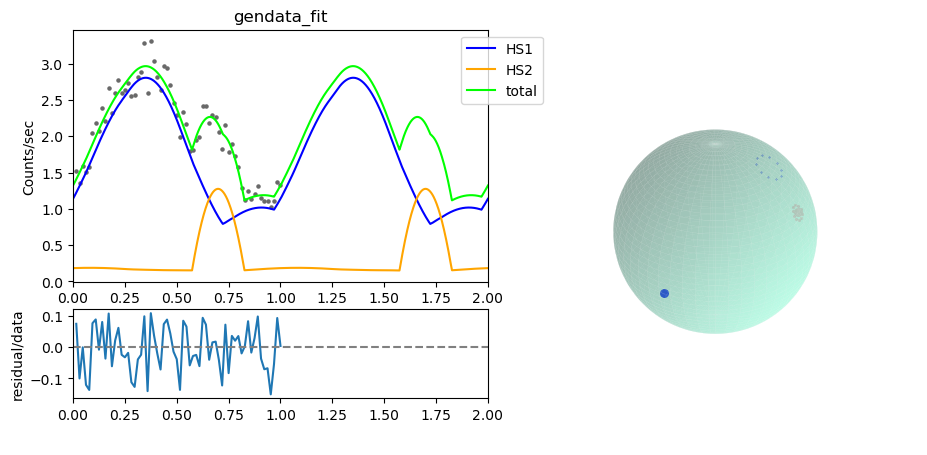

inclination angle: 33.10049733667772
Hot_spot_1: 97.80534280539999 124.30521894913834 3.472712922211412
Hot_spot_1_sub: 4.549526771522408 0.17365798609734026
Hot_spot_2: 147.44665255205854 251.9695323091431 19.422836929820622
Hot_spot_1_sub: 188.23992864258815 0.05116718023795183
INPUT
44.3
HS1_main
89.9
124.0
1.39
HS1_sub
8.2
0.099
HS2_main
159.7
249.7
12.73
HS2_sub
200.8
0


In [52]:
# SGR 0418+5729
# HS1,2 finite spots

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(85)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.33
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(252)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(1)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

def calculate_reduced_chi_square(data, model):
    RCS = scipy.stats.chisquare(data, model)
    return RCS
    

#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)



###################################################
###################################################
#################### generator ####################
###################################################
###################################################
# number of bin(20 - 80)
N_data = 64
x_pf_data_gen = []
for i in range(0, N_data):
    x_pf_data_gen.append((i + 1) / N_data)
print(x_pf_data_gen)
x_pf_data_gen_pandas = pd.Series(x_pf_data_gen)
# y_pf_data_gen = []

# model setup
inc_gen = np.radians(44.3)
# HS1 info / input
theta_1_main_gen = np.radians(89.9)
phi_1_main_gen = np.radians(124.0)
m_1_main_gen = 1.39
ang_1_sub_gen = np.radians(8.2)
m_1_sub_gen = 0.099
# HS2 info / input 
theta_2_main_gen = np.radians(159.7)
phi_2_main_gen = np.radians(249.7)
m_2_main_gen = 12.73
ang_2_sub_gen = np.radians(200.8)
m_2_sub_gen = 0

# random uncertainty attached
gen_data = mu_total(x_pf_data_gen_pandas, inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen)
###################################################
uncertainty = 0.25
###################################################
for i in range(0, N_data):
    upper_data_limit = gen_data[i] + uncertainty * gen_data[i]
    lower_data_limit = gen_data[i] - uncertainty * gen_data[i]
    gen_data[i] = gen_data[i] + random.uniform(lower_data_limit, upper_data_limit)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])

parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)

y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.cos(parameter_optimal_gen[2])
x_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.cos(parameter_optimal_gen[7])
y_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.sin(parameter_optimal_gen[2])
y_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.sin(parameter_optimal_gen[7])
z_hs_1 = scale * r * np.cos(parameter_optimal_gen[1])
z_hs_2 = scale * r * np.cos(parameter_optimal_gen[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "pink")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "blue")

HS_sub_plot_size_1 = parameter_optimal_gen[5] / parameter_optimal_gen[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal_gen[10] / parameter_optimal_gen[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1_gen = drawing_sub_hs(parameter_optimal_gen[4], N_sub, parameter_optimal_gen[1], parameter_optimal_gen[2])
print(hs_sub_draw_1_gen)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1_gen[0, i+1], hs_sub_draw_1_gen[1, i+1], hs_sub_draw_1_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2_gen = drawing_sub_hs(parameter_optimal_gen[9], N_sub, parameter_optimal_gen[6], parameter_optimal_gen[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2_gen[0, i+1], hs_sub_draw_2_gen[1, i+1], hs_sub_draw_2_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5])
HS2 = HS2(x, parameter_optimal_gen[0], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# data of pulse profile
ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting_gen, label = 'total', color = 'lime')
# info
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("gendata_fit")
# ax.text(1.8, 0.325, r"$\theta = \frac{\pi}{5}$")
# ax.text(1.8, 0.31, r"$i = \frac{\pi}{3}$")
# ax.text(1.8, 0.295, r"$\phi = \pi$")
# ax.text(0.8, 0.32, r"$amp = 0.345$")
# plt.title("3XMM J185246.6+003317のパルス波形と手合わせ曲線", fontname = "MS Gothic")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal_gen[0]), azim = 0)
ax2.axis("off")

# ax3.plot(x_data, y_data - func(x_data, a_p_1, b, c_p_1, d_p_1) - func(x_data, a_p_2, b, c_p_2, d_p_2) - func(x_data, a_p_3, b, c_p_3, d_p_3))
ax3.plot(x_pf_data_gen, (gen_data - y_fitting_same_size_as_y_data_gen) / gen_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("inclination angle:", np.degrees(parameter_optimal_gen[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal_gen[1]), np.degrees(parameter_optimal_gen[2]), parameter_optimal_gen[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[4]), parameter_optimal_gen[5])
print("Hot_spot_2:", np.degrees(parameter_optimal_gen[6]), np.degrees(parameter_optimal_gen[7]), parameter_optimal_gen[8])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[9]), parameter_optimal_gen[10])

print("INPUT")
print(np.degrees(inc_gen))
print("HS1_main")
print(np.degrees(theta_1_main_gen))
print(np.degrees(phi_1_main_gen))
print(m_1_main_gen)
print("HS1_sub")
print(np.degrees(ang_1_sub_gen))
print(m_1_sub_gen)

print("HS2_main")
print(np.degrees(theta_2_main_gen))
print(np.degrees(phi_2_main_gen))
print(m_2_main_gen)
print("HS2_sub")
print(np.degrees(ang_2_sub_gen))
print(m_2_sub_gen)

36.0
36
0.0
6.283185307179586
[0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8125, 0.828125, 0.84375, 0.859375, 0.875, 0.890625, 0.90625, 0.921875, 0.9375, 0.953125, 0.96875, 0.984375, 1.0]
[[ 1.00030638 -0.52803896 -0.4558758  -0.40682941 -0.39963383 -0.43703755
  -0.5047536  -0.57691676 -0.62596316 -0.63315873 -0.59575501]
 [ 1.00030638  0.86069895  0.89998254  0.91701238  0.90528366  0.86927635
   0.82274402  0.78346043  0.76643058  0.7781593   0.81416662]
 [ 1.00030638 -0.02172953 -0.04804879 -0.11695351 -0.20212444 -0.27102917
  -0.29734843 -0.27102917 -0.20212444 -0.11

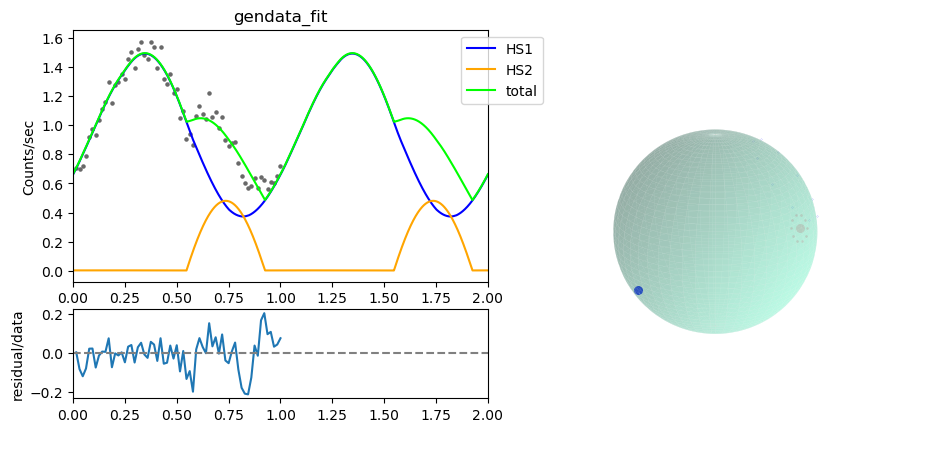

FITTING
inclination angle: 20.840064098744165
Hot_spot_1: 99.17730176149945 121.52912317106139 2.674420044763352
Hot_spot_1_sub: -7.944523383742303 0.06980850571105805
Hot_spot_2: 130.070566578921 264.9588273630278 4.206949952427578
Hot_spot_2_sub: 209.03424666411988 0.0009550544776422373

INPUT
inclination angle: 41.9884089720813
Hot_spot_1: 107.77243791428974 137.02956151673547 1.5740203606137517
Hot_spot_1_sub: 7.359986104488588 0.09626456009881719
Hot_spot_2: 138.97965918375584 237.42321476487416 12.188870375306742
Hot_spot_2_sub: 176.79414715727773 0.0

INPUT
inclination angle: 44.3
Hot_spot_1: 89.9 124.0 1.39
Hot_spot_1_sub: 8.2 0.099
Hot_spot_2: 159.7 249.7 12.73
Hot_spot_2_sub: 200.8 0


In [87]:
# SGR 0418+5729
# HS1,2 finite spots

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(85)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.33
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(252)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(1)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

def calculate_reduced_chi_square(data, model):
    RCS = scipy.stats.chisquare(data, model)
    return RCS
    

#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)



###################################################
###################################################
#################### generator ####################
###################################################
###################################################
# number of bin(20 - 80)
N_data = 64
x_pf_data_gen = []
for i in range(0, N_data):
    x_pf_data_gen.append((i + 1) / N_data)
print(x_pf_data_gen)
x_pf_data_gen_pandas = pd.Series(x_pf_data_gen)
# y_pf_data_gen = []

# model setup
inc_gen = np.radians(44.3)
# HS1 info / input
theta_1_main_gen = np.radians(89.9)
phi_1_main_gen = np.radians(124.0)
m_1_main_gen = 1.39
ang_1_sub_gen = np.radians(8.2)
m_1_sub_gen = 0.099
# HS2 info / input 
theta_2_main_gen = np.radians(159.7)
phi_2_main_gen = np.radians(249.7)
m_2_main_gen = 12.73
ang_2_sub_gen = np.radians(200.8)
m_2_sub_gen = 0

# initial setup, 50% uncertainty random attach function
def ini_uncertainty(x):
    # 50%
    uncertainty = 0.2
    upper_limit = x + uncertainty * x
    lower_limit = x - uncertainty * x
    ini_x = random.uniform(lower_limit, upper_limit)
    return ini_x

# # initial setup
# inc_gen_ini = np.radians(30)
# # HS1 info / input
# theta_1_main_gen_ini = np.radians(20)
# phi_1_main_gen_ini = np.radians(190)
# m_1_main_gen_ini = 1.5
# ang_1_sub_gen_ini = np.radians(10)
# m_1_sub_gen_ini = 0.1
# # HS2 info / input 
# theta_2_main_gen_ini = np.radians(160)
# phi_2_main_gen_ini = np.radians(300)
# m_2_main_gen_ini = 10
# ang_2_sub_gen_ini = np.radians(5)
# m_2_sub_gen_ini = 0.1

# initial setup
inc_gen_ini = ini_uncertainty(inc_gen)
# HS1 info / input
theta_1_main_gen_ini = ini_uncertainty(theta_1_main_gen)
phi_1_main_gen_ini = ini_uncertainty(phi_1_main_gen)
m_1_main_gen_ini = ini_uncertainty(m_1_main_gen)
ang_1_sub_gen_ini = ini_uncertainty(ang_1_sub_gen)
m_1_sub_gen_ini = ini_uncertainty(m_1_sub_gen)
# HS2 info / input 
theta_2_main_gen_ini = ini_uncertainty(theta_2_main_gen)
phi_2_main_gen_ini = ini_uncertainty(phi_2_main_gen)
m_2_main_gen_ini = ini_uncertainty(m_2_main_gen)
ang_2_sub_gen_ini = ini_uncertainty(ang_2_sub_gen)
m_2_sub_gen_ini = ini_uncertainty(m_2_sub_gen)

# random uncertainty attached
gen_data = mu_total(x_pf_data_gen_pandas, inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen)

###################################################

uncertainty = 0.1

###################################################

for i in range(0, N_data):
    upper_data_limit = gen_data[i] + uncertainty * gen_data[i]
    lower_data_limit = gen_data[i] - uncertainty * gen_data[i]
    gen_data[i] = random.uniform(lower_data_limit, upper_data_limit)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen_ini)

y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.cos(parameter_optimal_gen[2])
x_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.cos(parameter_optimal_gen[7])
y_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.sin(parameter_optimal_gen[2])
y_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.sin(parameter_optimal_gen[7])
z_hs_1 = scale * r * np.cos(parameter_optimal_gen[1])
z_hs_2 = scale * r * np.cos(parameter_optimal_gen[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "pink")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "blue")

HS_sub_plot_size_1 = parameter_optimal_gen[5] / parameter_optimal_gen[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal_gen[10] / parameter_optimal_gen[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1_gen = drawing_sub_hs(parameter_optimal_gen[4], N_sub, parameter_optimal_gen[1], parameter_optimal_gen[2])
print(hs_sub_draw_1_gen)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1_gen[0, i+1], hs_sub_draw_1_gen[1, i+1], hs_sub_draw_1_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2_gen = drawing_sub_hs(parameter_optimal_gen[9], N_sub, parameter_optimal_gen[6], parameter_optimal_gen[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2_gen[0, i+1], hs_sub_draw_2_gen[1, i+1], hs_sub_draw_2_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5])
HS2 = HS2(x, parameter_optimal_gen[0], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# data of pulse profile
ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting_gen, label = 'total', color = 'lime')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("gendata_fit")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal_gen[0]), azim = 0)
ax2.axis("off")

ax3.plot(x_pf_data_gen, (gen_data - y_fitting_same_size_as_y_data_gen) / gen_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal_gen[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal_gen[1]), np.degrees(parameter_optimal_gen[2]), parameter_optimal_gen[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[4]), parameter_optimal_gen[5])
print("Hot_spot_2:", np.degrees(parameter_optimal_gen[6]), np.degrees(parameter_optimal_gen[7]), parameter_optimal_gen[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal_gen[9]), parameter_optimal_gen[10])

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen_ini))
print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen))
print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)

In [88]:
print("")

36.0
36
0.0
6.283185307179586
[0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8125, 0.828125, 0.84375, 0.859375, 0.875, 0.890625, 0.90625, 0.921875, 0.9375, 0.953125, 0.96875, 0.984375, 1.0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-0.60557042 -0.00662241  0.45765966  0.72771002  0.70037861  0.38610512
  -0.09506868 -0.55935074 -0.8294011  -0.8020697  -0.4877962 ]
 [-0.60557042 -0.0657496  -0.1972171  -0.44617566 -0.71753

/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


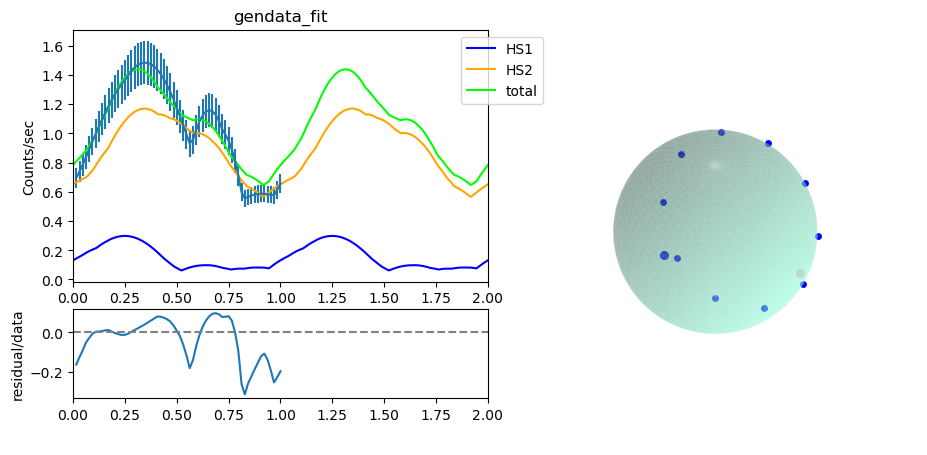

FITTING
inclination angle: 51.4598014656621
Hot_spot_1: 123.08801461076197 84.24847421897572 0.47380335301308496
Hot_spot_1_sub: -126.83944191326964 -0.12371553487898546
Hot_spot_2: 142.07716464979356 238.16055802709354 0.6231115241344322
Hot_spot_2_sub: 240.5637075192012 0.32377362217451894

INPUT
inclination angle: 40.89538592493349
Hot_spot_1: 99.82345848257239 123.01215419084326 1.6637580242677887
Hot_spot_1_sub: 7.821186834659195 0.1172614589220905
Hot_spot_2: 131.5249322438451 258.02571712867905 14.139763939845068
Hot_spot_2_sub: 230.52335702437315 0.0

INPUT
inclination angle: 44.3
Hot_spot_1: 89.9 124.0 1.39
Hot_spot_1_sub: 8.2 0.099
Hot_spot_2: 159.7 249.7 12.73
Hot_spot_2_sub: 200.8 0


In [94]:
# SGR 0418+5729
# HS1,2 finite spots
# error fitting, errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]



# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(85)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.33
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(252)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(1)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

def calculate_reduced_chi_square(data, model):
    RCS = scipy.stats.chisquare(data, model)
    return RCS
    

#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)



###################################################
###################################################
#################### generator ####################
###################################################
###################################################
# number of bin(20 - 80)
N_data = 64
x_pf_data_gen = []
for i in range(0, N_data):
    x_pf_data_gen.append((i + 1) / N_data)
print(x_pf_data_gen)
x_pf_data_gen_pandas = pd.Series(x_pf_data_gen)
# y_pf_data_gen = []

# model setup
inc_gen = np.radians(44.3)
# HS1 info / input
theta_1_main_gen = np.radians(89.9)
phi_1_main_gen = np.radians(124.0)
m_1_main_gen = 1.39
ang_1_sub_gen = np.radians(8.2)
m_1_sub_gen = 0.099
# HS2 info / input 
theta_2_main_gen = np.radians(159.7)
phi_2_main_gen = np.radians(249.7)
m_2_main_gen = 12.73
ang_2_sub_gen = np.radians(200.8)
m_2_sub_gen = 0

# initial setup, 20% uncertainty random attach function
def ini_uncertainty(x):
    # 20%
    uncertainty = 0.2
    upper_limit = x + uncertainty * x
    lower_limit = x - uncertainty * x
    ini_x = random.uniform(lower_limit, upper_limit)
    return ini_x

# # initial setup
# inc_gen_ini = np.radians(30)
# # HS1 info / input
# theta_1_main_gen_ini = np.radians(20)
# phi_1_main_gen_ini = np.radians(190)
# m_1_main_gen_ini = 1.5
# ang_1_sub_gen_ini = np.radians(10)
# m_1_sub_gen_ini = 0.1
# # HS2 info / input 
# theta_2_main_gen_ini = np.radians(160)
# phi_2_main_gen_ini = np.radians(300)
# m_2_main_gen_ini = 10
# ang_2_sub_gen_ini = np.radians(5)
# m_2_sub_gen_ini = 0.1

# initial setup
inc_gen_ini = ini_uncertainty(inc_gen)
# HS1 info / input
theta_1_main_gen_ini = ini_uncertainty(theta_1_main_gen)
phi_1_main_gen_ini = ini_uncertainty(phi_1_main_gen)
m_1_main_gen_ini = ini_uncertainty(m_1_main_gen)
ang_1_sub_gen_ini = ini_uncertainty(ang_1_sub_gen)
m_1_sub_gen_ini = ini_uncertainty(m_1_sub_gen)
# HS2 info / input 
theta_2_main_gen_ini = ini_uncertainty(theta_2_main_gen)
phi_2_main_gen_ini = ini_uncertainty(phi_2_main_gen)
m_2_main_gen_ini = ini_uncertainty(m_2_main_gen)
ang_2_sub_gen_ini = ini_uncertainty(ang_2_sub_gen)
m_2_sub_gen_ini = ini_uncertainty(m_2_sub_gen)

# random uncertainty attached
pregen_data = mu_total(x_pf_data_gen_pandas, inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen)

###################################################

uncertainty = 0.1

###################################################
gen_data = np.empty(N_data)
print(gen_data)
for i in range(0, N_data):
    upper_data_limit = pregen_data[i] + uncertainty * gen_data[i]
    lower_data_limit = pregen_data[i] - uncertainty * gen_data[i]
    gen_data[i] = random.uniform(lower_data_limit, upper_data_limit)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen_ini)

y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.cos(parameter_optimal_gen[2])
x_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.cos(parameter_optimal_gen[7])
y_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.sin(parameter_optimal_gen[2])
y_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.sin(parameter_optimal_gen[7])
z_hs_1 = scale * r * np.cos(parameter_optimal_gen[1])
z_hs_2 = scale * r * np.cos(parameter_optimal_gen[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "pink")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "blue")

HS_sub_plot_size_1 = parameter_optimal_gen[5] / parameter_optimal_gen[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal_gen[10] / parameter_optimal_gen[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1_gen = drawing_sub_hs(parameter_optimal_gen[4], N_sub, parameter_optimal_gen[1], parameter_optimal_gen[2])
print(hs_sub_draw_1_gen)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1_gen[0, i+1], hs_sub_draw_1_gen[1, i+1], hs_sub_draw_1_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2_gen = drawing_sub_hs(parameter_optimal_gen[9], N_sub, parameter_optimal_gen[6], parameter_optimal_gen[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2_gen[0, i+1], hs_sub_draw_2_gen[1, i+1], hs_sub_draw_2_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5])
HS2 = HS2(x, parameter_optimal_gen[0], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
print(uncertainty)
ax1.errorbar(x_pf_data_gen, gen_data, yerr = uncertainty * gen_data)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting_gen, label = 'total', color = 'lime')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("gendata_fit")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal_gen[0]), azim = 0)
ax2.axis("off")

ax3.plot(x_pf_data_gen, (gen_data - y_fitting_same_size_as_y_data_gen) / gen_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal_gen[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal_gen[1]), np.degrees(parameter_optimal_gen[2]), parameter_optimal_gen[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[4]), parameter_optimal_gen[5])
print("Hot_spot_2:", np.degrees(parameter_optimal_gen[6]), np.degrees(parameter_optimal_gen[7]), parameter_optimal_gen[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal_gen[9]), parameter_optimal_gen[10])

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen_ini))
print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen))
print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)

36.0
36
0.0
6.283185307179586
[0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8125, 0.828125, 0.84375, 0.859375, 0.875, 0.890625, 0.90625, 0.921875, 0.9375, 0.953125, 0.96875, 0.984375, 1.0]
[[ 1.00431573 -0.54774473 -0.60112482 -0.63600797 -0.63907001 -0.60914134
  -0.5576537  -0.50427361 -0.46939045 -0.46632841 -0.49625708]
 [ 1.00431573  0.82683746  0.7935306   0.77580253  0.78042477  0.80563178
   0.84179535  0.87510221  0.89283028  0.88820803  0.86300102]
 [ 1.00431573 -0.19082854 -0.1704645  -0.11715075 -0.05125132  0.00206243
   0.02242647  0.00206243 -0.05125132 -0.11

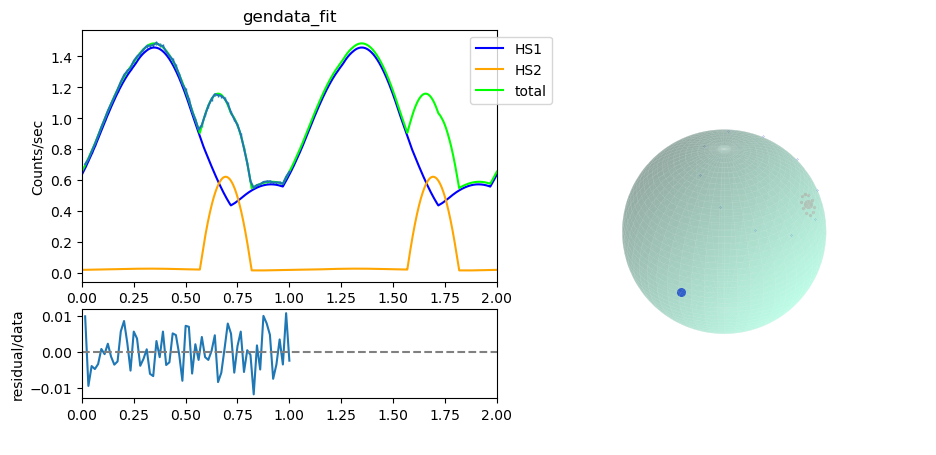

FITTING
inclination angle: 38.08297785018807
Hot_spot_1: 94.80927802081507 123.52278357012156 1.5606582728457725
Hot_spot_1_sub: 6.081602594782447 0.09713977218973373
Hot_spot_2: 152.77073066320062 249.58001564565228 11.007229193536979
Hot_spot_2_sub: 219.1822829284518 0.0072556352716119125
REDUCED CHI SQUARE:
0.31828350266579075

INPUT
inclination angle: 37.66437994898822
Hot_spot_1: 96.54730237860115 108.28794795137613 1.192569820856345
Hot_spot_1_sub: 8.627038688126898 0.10008010288752527
Hot_spot_2: 151.83157155087235 266.7020226964298 11.622687037167942
Hot_spot_2_sub: 187.1613440551002 0.0

Original
inclination angle: 44.3
Hot_spot_1: 89.9 124.0 1.39
Hot_spot_1_sub: 8.2 0.099
Hot_spot_2: 159.7 249.7 12.73
Hot_spot_2_sub: 200.8 0


In [4]:
# SGR 0418+5729
# HS1,2 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR 0418+5729_first(blue)_obs.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(85)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.33
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(252)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(1)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty[i] ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)



###################################################
###################################################
#################### generator ####################
###################################################
###################################################
# number of data(20 - 80)
N_data = 64
x_pf_data_gen = []
for i in range(0, N_data):
    x_pf_data_gen.append((i + 1) / N_data)
print(x_pf_data_gen)
x_pf_data_gen_pandas = pd.Series(x_pf_data_gen)
# y_pf_data_gen = []

# generate test data using 2 finite spots model (fitting result of SGR 0418+5729)
inc_gen = np.radians(44.3)
# HS1 input
theta_1_main_gen = np.radians(89.9)
phi_1_main_gen = np.radians(124.0)
m_1_main_gen = 1.39
ang_1_sub_gen = np.radians(8.2)
m_1_sub_gen = 0.099
# HS2 input 
theta_2_main_gen = np.radians(159.7)
phi_2_main_gen = np.radians(249.7)
m_2_main_gen = 12.73
ang_2_sub_gen = np.radians(200.8)
m_2_sub_gen = 0

# initial setup, 15% uncertainty random attach function
def ini_uncertainty(x):
    # 15%
    uncertainty = 0.15
    upper_limit = x + uncertainty * x
    lower_limit = x - uncertainty * x
    ini_x = random.uniform(lower_limit, upper_limit)
    return ini_x

# # initial setup
# inc_gen_ini = np.radians(30)
# # HS1 info / input
# theta_1_main_gen_ini = np.radians(20)
# phi_1_main_gen_ini = np.radians(190)
# m_1_main_gen_ini = 1.5
# ang_1_sub_gen_ini = np.radians(10)
# m_1_sub_gen_ini = 0.1
# # HS2 info / input 
# theta_2_main_gen_ini = np.radians(160)
# phi_2_main_gen_ini = np.radians(300)
# m_2_main_gen_ini = 10
# ang_2_sub_gen_ini = np.radians(5)
# m_2_sub_gen_ini = 0.1

degree_of_freedom = 0
# initial setup
inc_gen_ini = ini_uncertainty(inc_gen)
degree_of_freedom += 1
# HS1 info / input
theta_1_main_gen_ini = ini_uncertainty(theta_1_main_gen)
phi_1_main_gen_ini = ini_uncertainty(phi_1_main_gen)
m_1_main_gen_ini = ini_uncertainty(m_1_main_gen)
ang_1_sub_gen_ini = ini_uncertainty(ang_1_sub_gen)
m_1_sub_gen_ini = ini_uncertainty(m_1_sub_gen)
degree_of_freedom += 5
# HS2 info / input 
theta_2_main_gen_ini = ini_uncertainty(theta_2_main_gen)
phi_2_main_gen_ini = ini_uncertainty(phi_2_main_gen)
m_2_main_gen_ini = ini_uncertainty(m_2_main_gen)
ang_2_sub_gen_ini = ini_uncertainty(ang_2_sub_gen)
m_2_sub_gen_ini = ini_uncertainty(m_2_sub_gen)
degree_of_freedom += 5

# random uncertainty attached
pregen_data = mu_total(x_pf_data_gen_pandas, inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen)

###################################################

# poission error #

###################################################

gen_data = np.empty(N_data)
poission_error = np.empty(N_data)
# https://arxiv.org/pdf/1303.5579.pdf   check 3.1
binning = 100
for i in range(0, N_data):
    poission_error[i] = np.sqrt(pregen_data[i]) / binning
    upper_data_limit = pregen_data[i] + poission_error[i]
    lower_data_limit = pregen_data[i] - poission_error[i]
    gen_data[i] = random.uniform(lower_data_limit, upper_data_limit)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, sigma = poission_error, p0 = parameter_initial_test_gen_ini)

y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(gen_data, y_fitting_same_size_as_y_data_gen, poission_error, degree_of_freedom)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.cos(parameter_optimal_gen[2])
x_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.cos(parameter_optimal_gen[7])
y_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.sin(parameter_optimal_gen[2])
y_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.sin(parameter_optimal_gen[7])
z_hs_1 = scale * r * np.cos(parameter_optimal_gen[1])
z_hs_2 = scale * r * np.cos(parameter_optimal_gen[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "pink")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "blue")

HS_sub_plot_size_1 = parameter_optimal_gen[5] / parameter_optimal_gen[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal_gen[10] / parameter_optimal_gen[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1_gen = drawing_sub_hs(parameter_optimal_gen[4], N_sub, parameter_optimal_gen[1], parameter_optimal_gen[2])
print(hs_sub_draw_1_gen)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1_gen[0, i+1], hs_sub_draw_1_gen[1, i+1], hs_sub_draw_1_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2_gen = drawing_sub_hs(parameter_optimal_gen[9], N_sub, parameter_optimal_gen[6], parameter_optimal_gen[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2_gen[0, i+1], hs_sub_draw_2_gen[1, i+1], hs_sub_draw_2_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5])
HS2 = HS2(x, parameter_optimal_gen[0], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# data of pulse profile
# ax1.scatter(x_pf_data_gen, gen_data, s = 5, c = "dimgrey")
# print(uncertainty)
ax1.errorbar(x_pf_data_gen, gen_data, yerr = poission_error, elinewidth = 1)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "orange")
ax1.plot(x, y_fitting_gen, label = 'total', color = 'lime')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("gendata_fit")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = np.degrees(parameter_optimal_gen[0]), azim = 0)
ax2.axis("off")

ax3.plot(x_pf_data_gen, (gen_data - y_fitting_same_size_as_y_data_gen) / gen_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal_gen[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal_gen[1]), np.degrees(parameter_optimal_gen[2]), parameter_optimal_gen[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[4]), parameter_optimal_gen[5])
print("Hot_spot_2:", np.degrees(parameter_optimal_gen[6]), np.degrees(parameter_optimal_gen[7]), parameter_optimal_gen[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal_gen[9]), parameter_optimal_gen[10])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen_ini))
print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

print("")

print("Original")
print("inclination angle:", np.degrees(inc_gen))
print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)

36.0
36
0.0
6.283185307179586
[0.016666666666666666, 0.03333333333333333, 0.05, 0.06666666666666667, 0.08333333333333333, 0.1, 0.11666666666666667, 0.13333333333333333, 0.15, 0.16666666666666666, 0.18333333333333332, 0.2, 0.21666666666666667, 0.23333333333333334, 0.25, 0.26666666666666666, 0.2833333333333333, 0.3, 0.31666666666666665, 0.3333333333333333, 0.35, 0.36666666666666664, 0.38333333333333336, 0.4, 0.4166666666666667, 0.43333333333333335, 0.45, 0.4666666666666667, 0.48333333333333334, 0.5, 0.5166666666666667, 0.5333333333333333, 0.55, 0.5666666666666667, 0.5833333333333334, 0.6, 0.6166666666666667, 0.6333333333333333, 0.65, 0.6666666666666666, 0.6833333333333333, 0.7, 0.7166666666666667, 0.7333333333333333, 0.75, 0.7666666666666667, 0.7833333333333333, 0.8, 0.8166666666666667, 0.8333333333333334, 0.85, 0.8666666666666667, 0.8833333333333333, 0.9, 0.9166666666666666, 0.9333333333333333, 0.95, 0.9666666666666667, 0.9833333333333333, 1.0]
[[ 0.9408559  -0.66775109 -0.50603948 -0.3

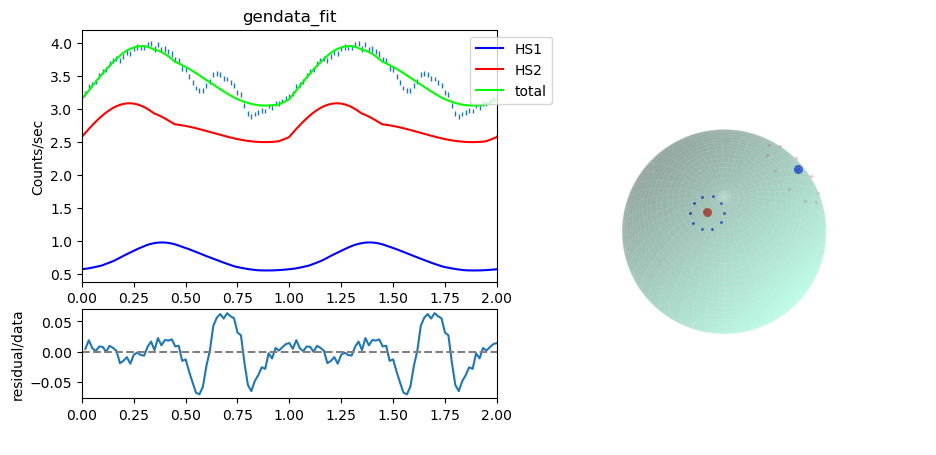

FITTING
inclination angle: 19.142202088242808
Hot_spot_1: 95.67234944661247 133.36142307798477 1.410356050213865
Hot_spot_1_sub: -21.323762641610365 0.09065878134485414
Hot_spot_2: 147.9261960530633 199.18313984574576 16.873834785737664
Hot_spot_2_sub: 10.052354322621415 0.5703853693754125
REDUCED CHI SQUARE:
10.006705050113743

INPUT
inclination angle: 41.371752071485574
Hot_spot_1: 99.74568827394324 127.3364735530142 1.5703673611245499
Hot_spot_1_sub: 11.96010329013807 0.09355017619812854
Hot_spot_2: 165.0899793151372 232.78041934828664 16.873834785737664
Hot_spot_2_sub: 4.760150335203855 0.5717340676373948

Original
inclination angle: 44.03
Hot_spot_1: 92.5 123.45 1.43
Hot_spot_1_sub: 11.44 0.103
Hot_spot_2: 159.97 247.9 14.9
Hot_spot_2_sub: 5.0 0.5


In [2]:
# SGR 0418+5729
# HS1,2 finite spots
# error fitting (Poission distribution), errorbar plot

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
import math
import scipy.optimize
import scipy.stats
import os
import matplotlib
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random

# load data
# magnetar SGR 0418+5729 from paper:
df = pd.read_csv('SGR0148+5729_230307.csv', header = 0)
x_data = df.iloc[:,0]
y_data = df.iloc[:,1]

# geometric figure
# Create a new figure
fig = plt.figure(figsize = (12.0, 6.0), dpi = 100)
ax2 = plt.subplot2grid((20, 11), (2, 5), rowspan = 18, colspan = 5, projection = "3d")
ax1 = plt.subplot2grid((20, 11), (2, 0), rowspan = 11, colspan = 5)
ax3 = plt.subplot2grid((20, 11), (14, 0), rowspan = 4, colspan = 5)
# Get the current axes, and tell Matplotlib to use the 3D projection

# Set the scaling factor for the sphere
scale = 1.01

# Create a sphere
r = 1 # radius
phi_sphere, theta_sphere = np.mgrid[0:np.pi:100j, 0:2 * np.pi:100j]
x_sphere = r * np.sin(phi_sphere) * np.cos(theta_sphere)
y_sphere = r * np.sin(phi_sphere) * np.sin(theta_sphere)
z_sphere = r * np.cos(phi_sphere)

# Plot the sphere
ax2.plot_surface(x_sphere, y_sphere, z_sphere, alpha = 0.3, color = "aquamarine", edgecolor = "w", linewidth = 0.1)



# pulse profile
# theta = pi / 5
# i = pi / 3
# a = theta, b = i, c = phi, d = normalization
# initial parameter setting
i_ini = np.radians(44)
# HS1
theta_1_main_ini = np.radians(85)
phi_1_main_ini = np.radians(124)
m_1_main_ini = 1.33
ang_1_sub_ini = np.radians(11)
m_1_sub_ini = 0.1

# HS2
theta_2_main_ini = np.radians(160)
phi_2_main_ini = np.radians(252)
m_2_main_ini = 10
ang_2_sub_ini = np.radians(1)
m_2_sub_ini = 0.01

# light-bending factor
f_lb = 1. / 3.

# sub_hot_spot_number
N_sub = 10

print(360 / N_sub)
print(int(360 / N_sub))
print(360 / N_sub - int(360 / N_sub))

pi_times_2 = 2. * math.pi
print(pi_times_2)

#############################################################################################
# function area

def mu(x, i, theta, phi, m):
    y = np.sin(theta) * np.sin(i) * np.cos(pi_times_2 * x - phi) + np.cos(theta) * np.cos(i)
    F = m * (y * (1. - f_lb) + f_lb)
    result = (abs(F) + F) / 2
    return result

def rectangular_to_polar_theta(z):
    theta_polar = np.arccos(z / (r * scale))
    return theta_polar

def rectangular_to_polar_phi(x, y):
    phi_polar = np.arctan(y / x)
    return phi_polar

def polar_to_rectangular_x(theta, phi):
    x_rectangular = scale * r * np.sin(theta) * np.cos(phi)
    return x_rectangular

def polar_to_rectangular_y(theta, phi):
    y_rectangular = scale * r * np.sin(theta) * np.sin(phi)
    return y_rectangular

def polar_to_rectangular_z(theta):
    z_rectangular = scale * r * np.cos(theta)
    return z_rectangular

def rotation_matrix(theta, phi, x, y, z):
    xyz = np.array([[x], [y], [z]])
    z_rot = np.array([[np.cos(-phi), np.sin(-phi), 0], [-np.sin(-phi), np.cos(-phi), 0], [0, 0 ,1]])
    y_rot = np.array([[np.cos(-theta), 0, -np.sin(-theta)], [0, 1, 0], [np.sin(-theta), 0, np.cos(-theta)]])
    XYZ_after_rotation = np.dot(z_rot, np.dot(y_rot, xyz))
    return XYZ_after_rotation

def sub_hot_spot_hs(N_sub, ang, theta_main, phi_main):
    delta_phi = 360 / N_sub
    temp_phi = 0
    x_hs_sub = np.empty(0)
    y_hs_sub = np.empty(0)
    z_hs_sub = np.empty(0)
    for i in range(0, N_sub):
        x_hs_sub = np.append(x_hs_sub, polar_to_rectangular_x(ang, np.radians(temp_phi)))
        y_hs_sub = np.append(y_hs_sub, polar_to_rectangular_y(ang, np.radians(temp_phi)))
        z_hs_sub = np.append(z_hs_sub, polar_to_rectangular_z(ang))
        temp_phi += delta_phi
    hs_sub_XYZ = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_XYZ = np.append(hs_sub_XYZ, rotation_matrix(theta_main, phi_main, x_hs_sub[i], y_hs_sub[i], z_hs_sub[i]), axis = 1)
    hs_sub_theta = np.empty(0)
    hs_sub_phi = np.empty(0)
    for i in range(0, N_sub):
        hs_sub_theta = np.append(hs_sub_theta, rectangular_to_polar_theta(hs_sub_XYZ[2, i]))
        hs_sub_phi = np.append(hs_sub_phi, rectangular_to_polar_phi(hs_sub_XYZ[1, i], hs_sub_XYZ[0, i]))
    return hs_sub_XYZ, hs_sub_theta, hs_sub_phi

# def calculate_reduced_chi_square(data, model):
#     RCS = scipy.stats.chisquare(data, model)
#     return RCS

def calculate_reduced_chi_square(observed_data, model_predictions, uncertainty, degrees_of_freedom):
    number_of_observations = len(observed_data)
    chi_square = 0
    for i in range(0, number_of_observations):
        chi_square += (observed_data[i] - model_predictions[i]) ** 2 / uncertainty[i] ** 2
    reduced_chi_square = chi_square / (number_of_observations - degrees_of_freedom)
    return reduced_chi_square
    
    
#############################################################################################

def HS1(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    HS1 = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini)
    for i in range(0, N_sub):
        HS1 += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
    return HS1

def HS2(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    HS2 = mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        HS2 += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return HS2


def mu_total(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini, ang_1_sub_ini, m_1_sub_ini, theta_2_main_ini, phi_2_main_ini, m_2_main_ini, ang_2_sub_ini, m_2_sub_ini):
    # HS1 sub
    hs_1_sub_XYZ, hs_1_sub_theta, hs_1_sub_phi = sub_hot_spot_hs(N_sub, ang_1_sub_ini, theta_1_main_ini, phi_1_main_ini)
    # HS2 sub
    hs_2_sub_XYZ, hs_2_sub_theta, hs_2_sub_phi = sub_hot_spot_hs(N_sub, ang_2_sub_ini, theta_2_main_ini, phi_2_main_ini)
    # total
    Total = mu(x, i, theta_1_main_ini, phi_1_main_ini, m_1_main_ini) + \
            mu(x, i, theta_2_main_ini, phi_2_main_ini, m_2_main_ini)
    for i in range(0, N_sub):
        Total += mu(x, i, hs_1_sub_theta[i], hs_1_sub_phi[i], m_1_sub_ini)
        Total += mu(x, i, hs_2_sub_theta[i], hs_2_sub_phi[i], m_2_sub_ini)
    return Total

x = np.linspace(0, 2, 5000)



###################################################
###################################################
#################### generator ####################
###################################################
###################################################
# number of data(20 - 80)
N_data = 60
x_pf_data_gen = []
for i in range(0, N_data):
    x_pf_data_gen.append((i + 1) / N_data)
print(x_pf_data_gen)
x_pf_data_gen_pandas = pd.Series(x_pf_data_gen)
# y_pf_data_gen = []

# generate test data using 2 finite spots model (fitting result of SGR 0418+5729)
inc_gen = np.radians(44.03)
# HS1 input
theta_1_main_gen = np.radians(92.50)
phi_1_main_gen = np.radians(123.45)
m_1_main_gen = 1.43
ang_1_sub_gen = np.radians(11.44)
m_1_sub_gen = 0.103
# HS2 input 
theta_2_main_gen = np.radians(159.97)
phi_2_main_gen = np.radians(247.90)
m_2_main_gen = 14.90
ang_2_sub_gen = np.radians(5)
m_2_sub_gen = 0.5

# initial setup, 15% uncertainty random attach function
def ini_uncertainty(x):
    # 15%
    uncertainty = 0.15
    upper_limit = x + uncertainty * x
    lower_limit = x - uncertainty * x
    ini_x = random.uniform(lower_limit, upper_limit)
    return ini_x

# # initial setup
# inc_gen_ini = np.radians(30)
# # HS1 info / input
# theta_1_main_gen_ini = np.radians(20)
# phi_1_main_gen_ini = np.radians(190)
# m_1_main_gen_ini = 1.5
# ang_1_sub_gen_ini = np.radians(10)
# m_1_sub_gen_ini = 0.1
# # HS2 info / input 
# theta_2_main_gen_ini = np.radians(160)
# phi_2_main_gen_ini = np.radians(300)
# m_2_main_gen_ini = 10
# ang_2_sub_gen_ini = np.radians(5)
# m_2_sub_gen_ini = 0.1

degree_of_freedom = 0
# initial setup
inc_gen_ini = ini_uncertainty(inc_gen)
degree_of_freedom += 1
# HS1 info / input
theta_1_main_gen_ini = ini_uncertainty(theta_1_main_gen)
phi_1_main_gen_ini = ini_uncertainty(phi_1_main_gen)
m_1_main_gen_ini = ini_uncertainty(m_1_main_gen)
ang_1_sub_gen_ini = ini_uncertainty(ang_1_sub_gen)
m_1_sub_gen_ini = ini_uncertainty(m_1_sub_gen)
degree_of_freedom += 5
# HS2 info / input 
theta_2_main_gen_ini = ini_uncertainty(theta_2_main_gen)
phi_2_main_gen_ini = ini_uncertainty(phi_2_main_gen)
m_2_main_gen_ini = ini_uncertainty(m_2_main_gen)
ang_2_sub_gen_ini = ini_uncertainty(ang_2_sub_gen)
m_2_sub_gen_ini = ini_uncertainty(m_2_sub_gen)
degree_of_freedom += 5

# random uncertainty attached
pregen_data = mu_total(x_pf_data_gen_pandas, inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen)

###################################################
# poission error #
###################################################

gen_data = np.empty(N_data)
poission_error = np.empty(N_data)
# binning, https://arxiv.org/pdf/1303.5579.pdf   3.1, 3.2
binning = 50
for i in range(0, N_data):
    poission_error[i] = np.sqrt(pregen_data[i]) / binning
    upper_data_limit = pregen_data[i] + poission_error[i]
    lower_data_limit = pregen_data[i] - poission_error[i]
    gen_data[i] = random.uniform(lower_data_limit, upper_data_limit)

###################################################
###################################################
##################### fitting #####################
###################################################
###################################################

parameter_initial_test_gen = np.array([inc_gen, theta_1_main_gen, phi_1_main_gen, m_1_main_gen, ang_1_sub_gen, m_1_sub_gen, theta_2_main_gen, phi_2_main_gen, m_2_main_gen, ang_2_sub_gen, m_2_sub_gen])
parameter_initial_test_gen_ini = np.array([inc_gen_ini, theta_1_main_gen_ini, phi_1_main_gen_ini, m_1_main_gen_ini, ang_1_sub_gen_ini, m_1_sub_gen_ini, theta_2_main_gen_ini, phi_2_main_gen_ini, m_2_main_gen_ini, ang_2_sub_gen_ini, m_2_sub_gen_ini])

# parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, p0 = parameter_initial_test_gen)
parameter_optimal_gen, covariance_gen = scipy.optimize.curve_fit(mu_total, x_pf_data_gen, gen_data, sigma = poission_error, p0 = parameter_initial_test_gen_ini)

y_fitting_gen = mu_total(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])
y_fitting_same_size_as_y_data_gen = mu_total(x_pf_data_gen_pandas, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])



# reduced X^2
reduced_chi_square_gen_data_fit = calculate_reduced_chi_square(gen_data, y_fitting_same_size_as_y_data_gen, poission_error, degree_of_freedom)

###################################################
###################################################
#################### draw pic #####################
###################################################
###################################################

# draw positon of main
# positions of HS
x_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.cos(parameter_optimal_gen[2])
x_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.cos(parameter_optimal_gen[7])
y_hs_1 = scale * r * np.sin(parameter_optimal_gen[1]) * np.sin(parameter_optimal_gen[2])
y_hs_2 = scale * r * np.sin(parameter_optimal_gen[6]) * np.sin(parameter_optimal_gen[7])
z_hs_1 = scale * r * np.cos(parameter_optimal_gen[1])
z_hs_2 = scale * r * np.cos(parameter_optimal_gen[6])

x_hs = [x_hs_1, x_hs_2]
y_hs = [y_hs_1, y_hs_2]
z_hs = [z_hs_1, z_hs_2]

HS_main_plot_size = 30

ax2.scatter(x_hs[0], y_hs[0], z_hs[0], s = HS_main_plot_size, c = "blue")
ax2.scatter(x_hs[1], y_hs[1], z_hs[1], s = HS_main_plot_size, c = "red")

HS_sub_plot_size_1 = parameter_optimal_gen[5] / parameter_optimal_gen[3] * HS_main_plot_size
HS_sub_plot_size_2 = parameter_optimal_gen[10] / parameter_optimal_gen[8] * HS_main_plot_size

# function maybe useless, for maybe this func is repeating some of the funcs already been coded before
def drawing_sub_hs(theta_sub_fit, N_sub, theta_main_fit, phi_main_fit):
    x_draw = np.empty(0)
    y_draw = np.empty(0)
    z_draw = np.empty(0)
    for i in range(0, N_sub):
        x_draw = np.append(x_draw, polar_to_rectangular_x(theta_sub_fit, np.radians(i * 360 / N_sub)))
        y_draw = np.append(y_draw, polar_to_rectangular_y(theta_sub_fit, np.radians(i * 360 / N_sub)))
        z_draw = np.append(z_draw, polar_to_rectangular_z(theta_sub_fit))
    hs_sub_draw = np.empty((3, 1))
    for i in range(0, N_sub):
        hs_sub_draw = np.append(hs_sub_draw, rotation_matrix(theta_main_fit, phi_main_fit, x_draw[i], y_draw[i], z_draw[i]), axis = 1)
    return hs_sub_draw

hs_sub_draw_1_gen = drawing_sub_hs(parameter_optimal_gen[4], N_sub, parameter_optimal_gen[1], parameter_optimal_gen[2])
print(hs_sub_draw_1_gen)
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_1_gen[0, i+1], hs_sub_draw_1_gen[1, i+1], hs_sub_draw_1_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_1, c = "pink")

hs_sub_draw_2_gen = drawing_sub_hs(parameter_optimal_gen[9], N_sub, parameter_optimal_gen[6], parameter_optimal_gen[7])
for i in range(0, N_sub):
    ax2.scatter(hs_sub_draw_2_gen[0, i+1], hs_sub_draw_2_gen[1, i+1], hs_sub_draw_2_gen[2, i+1], zorder = 3, s = HS_sub_plot_size_2, c = "blue")

HS1 = HS1(x, parameter_optimal_gen[0], parameter_optimal_gen[1], parameter_optimal_gen[2], parameter_optimal_gen[3], parameter_optimal_gen[4], parameter_optimal_gen[5])
HS2 = HS2(x, parameter_optimal_gen[0], parameter_optimal_gen[6], parameter_optimal_gen[7], parameter_optimal_gen[8], parameter_optimal_gen[9], parameter_optimal_gen[10])

print("#####")
# theta_and_phi_of_subs
print("#####")

# data of pulse profile
# 2 periods
for i in range(0, len(gen_data)):
    x_pf_data_gen = np.append(x_pf_data_gen, x_pf_data_gen[i] + 1)
    gen_data = np.append(gen_data, gen_data[i])
    poission_error = np.append(poission_error, poission_error[i])
    y_fitting_same_size_as_y_data_gen = np.append(y_fitting_same_size_as_y_data_gen, y_fitting_same_size_as_y_data_gen[i])
ax1.errorbar(x_pf_data_gen, gen_data, yerr = poission_error, fmt = "none", elinewidth = 1)
# fitting of pulse profile
ax1.plot(x, HS1, label = "HS1", color = "blue")
ax1.plot(x, HS2, label = "HS2", color = "red")
ax1.plot(x, y_fitting_gen, label = 'total', color = 'lime')
ax1.set_xlim(0, 2)
ax1.set_xlabel('Phase')
ax1.set_ylabel('Counts/sec')
ax1.legend(bbox_to_anchor = (1.15, 1), loc = "upper right")
ax1.set_title("gendata_fit")

ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_zlim(-1.1, 1.1)
ax2.view_init(elev = 90 - np.degrees(parameter_optimal_gen[0]), azim = 0)
ax2.axis("off")

ax3.plot(x_pf_data_gen, (gen_data - y_fitting_same_size_as_y_data_gen) / gen_data)
ax3.axhline(y = 0, linestyle = '--', color = 'grey')
ax3.set_xlim(0, 2)
ax3.set_ylabel('residual/data')
plt.show()
print("FITTING")
print("inclination angle:", np.degrees(parameter_optimal_gen[0]))
print("Hot_spot_1:", np.degrees(parameter_optimal_gen[1]), np.degrees(parameter_optimal_gen[2]), parameter_optimal_gen[3])
print("Hot_spot_1_sub:", np.degrees(parameter_optimal_gen[4]), parameter_optimal_gen[5])
print("Hot_spot_2:", np.degrees(parameter_optimal_gen[6]), np.degrees(parameter_optimal_gen[7]), parameter_optimal_gen[8])
print("Hot_spot_2_sub:", np.degrees(parameter_optimal_gen[9]), parameter_optimal_gen[10])
print("REDUCED CHI SQUARE:")
print(reduced_chi_square_gen_data_fit)

print("")

print("INPUT")
print("inclination angle:", np.degrees(inc_gen_ini))
print("Hot_spot_1:", np.degrees(theta_1_main_gen_ini), np.degrees(phi_1_main_gen_ini), m_1_main_gen_ini)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen_ini), m_1_sub_gen_ini)
print("Hot_spot_2:", np.degrees(theta_2_main_gen_ini), np.degrees(phi_2_main_gen_ini), m_2_main_gen_ini)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen_ini), m_2_sub_gen_ini)

print("")

print("Original")
print("inclination angle:", np.degrees(inc_gen))
print("Hot_spot_1:", np.degrees(theta_1_main_gen), np.degrees(phi_1_main_gen), m_1_main_gen)
print("Hot_spot_1_sub:", np.degrees(ang_1_sub_gen), m_1_sub_gen)
print("Hot_spot_2:", np.degrees(theta_2_main_gen), np.degrees(phi_2_main_gen), m_2_main_gen)
print("Hot_spot_2_sub:", np.degrees(ang_2_sub_gen), m_2_sub_gen)